# Real-Time Info Midterm Assignment
## Group members: Purva Kapshikar, Hamzah Yaacob, and Jackson Zeng

## Research question
Which bus line among the AC Transit 19, 20, and 51A would benefit most from real-time information displays at some of their bus stops?

## Background

Include info on each bus line's headways


## Data sources

* US Census and ACS estimates: https://data.census.gov/
* AC Transit's Data API & Resource Center: https://www.actransit.org/data-api-resource-center
* MTC 511 Open Data (real-time delays): https://511.org/open-data/transit
* AC Transit on-time performance data

In [114]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import plotly.express as px
import folium

## Map of bus lines

We begin with showing the three bus lines (AC Transit 19, 20, and 51A) that we analyze in this project in the context of Oakland and Alameda.

In [76]:
bus_routes = gpd.read_file("data/bus-routes/filtered_bus_routes.shp")

The CRS of the bus routes shapefile is 4326, so we explicitly made it a geodataframe with that reference system.

In [77]:
bus_routes = gpd.GeoDataFrame(bus_routes, 
                      geometry="geometry", 
                      crs="EPSG:4326")

We then convert it to match the CRS of the `contextily` basemap.

In [78]:
bus_routes_wm = bus_routes.to_crs(epsg=3857)

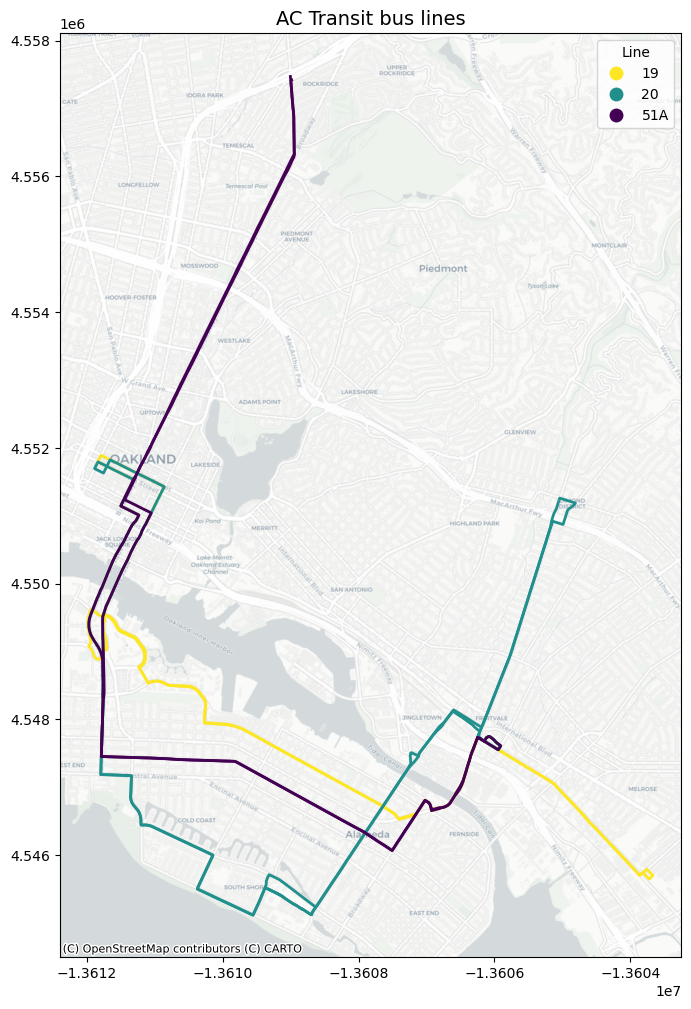

In [104]:
ax_br = bus_routes_wm.plot(column="PUB_RTE", legend=True, figsize=(10,12), linewidth=2, cmap="viridis_r",
                          legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': 'Line'
                         })
cx.add_basemap(ax_br, source=cx.providers.CartoDB.Positron)
plt.title(label="AC Transit bus lines",
          fontsize=14,
          color="black");

## Analysis of surrounding Census Tracts

To understand the surrounding area, we downloaded Census data on demographics, housing, and transportation characteristics from Social Explorer and used `geopandas`'s `plot` function to make choropleth maps.

In [18]:
census_tracts_data = pd.read_csv("data/census/census_tracts_data.csv")

In [19]:
census_tracts_data = census_tracts_data.dropna(axis=1,how="all")

We first convert the Social Explorer column names to more comprehensible ones.

In [20]:
columns_to_keep = ['Geo_FIPS',
                   'SE_A03001_001',
                   'SE_A03001_002',
                   'SE_A03001_003',
                   'SE_A03001_005',
                   'SE_A01001_011',
                   'SE_A01001_012',
                   'SE_A01001_013',
                   'SE_A14001_001',
                   'SE_A14001_002',
                   'SE_A14001_003',
                   'SE_A14001_004',
                   'SE_A14001_005',
                   'SE_A14001_006',
                   'SE_A14001_007',
                   'SE_A14001_008',
                   'SE_A09005_001',
                   'SE_A09005_003']
census_tracts_data = census_tracts_data[columns_to_keep]

In [21]:
census_tracts_data.columns = ['FIPS',
                              'Total Population',
                              'White Alone',
                              'Black or African American Alone',
                              'Asian Alone',
                              '65 to 74 years',
                              '75 to 84 years',
                              '85 years and above',
                              'Households',
                              'Less than $10,000',
                              '$10,000 to $14,999',
                              '$15,000 to $19,999',
                              '$20,000 to $24,999',
                              '$25,000 to 29,999',
                              '$30,000 to $34,999',
                              '$35,000 to $39,999',
                              'Workers 16 years and over',
                              'Public Transportation (Includes Taxicab)']

In [22]:
geom_census_data = pd.read_csv('data/census/bus_route_tracts.csv')

In [23]:
geom_census_data = geom_census_data.rename(columns = {"GEOID":"FIPS"})
geom_census_data = geom_census_data[["FIPS", "geometry"]]

We have two datasets, one with the Social Explorer data, and one that has the tract geometries. We merge these on the `FIPS` column.

In [24]:
joined_census_data = census_tracts_data.merge(right=geom_census_data, on="FIPS")

As there is now a `geometry` column, we convert this dataframe to a geodataframe.

In [25]:
joined_census_data["geometry"] = gpd.GeoSeries.from_wkt(joined_census_data["geometry"])
joined_census_data = gpd.GeoDataFrame(joined_census_data, geometry="geometry")

We create variables for percent Black, percent Asian, percent low income, and percent taking transit using the Social Explorer data, as we believe this is easier to understand than actual counts through choropleth maps. We also use the `contextily` library for their basemaps -- here we've used CartoDB's Positron basemap. We also modify the `alpha` value so that the tracts are more transparent.

In [26]:
joined_census_data['PCT_Black'] = joined_census_data['Black or African American Alone']/joined_census_data['Total Population']*100

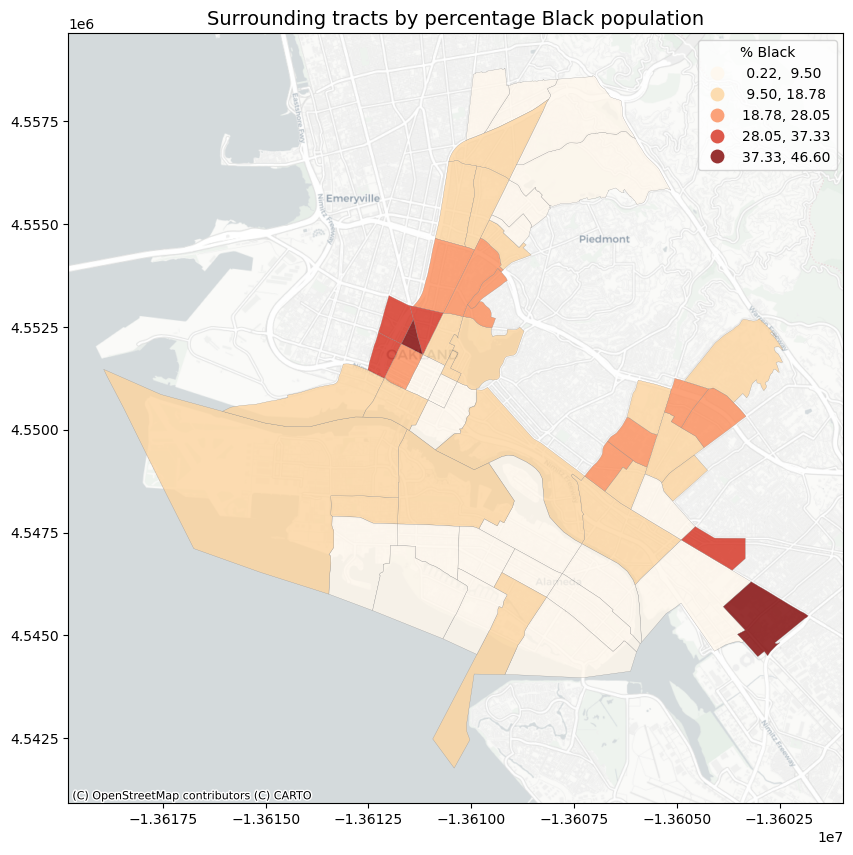

In [27]:
ax_bl = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Black',
                         legend=True,
                         cmap='OrRd',
                         scheme='equal_interval',
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': '% Black'
                         })
cx.add_basemap(ax_bl, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage Black population",
          fontsize=14,
          color="black");

In [28]:
joined_census_data['PCT_Asian'] = joined_census_data['Asian Alone']/joined_census_data['Total Population']*100

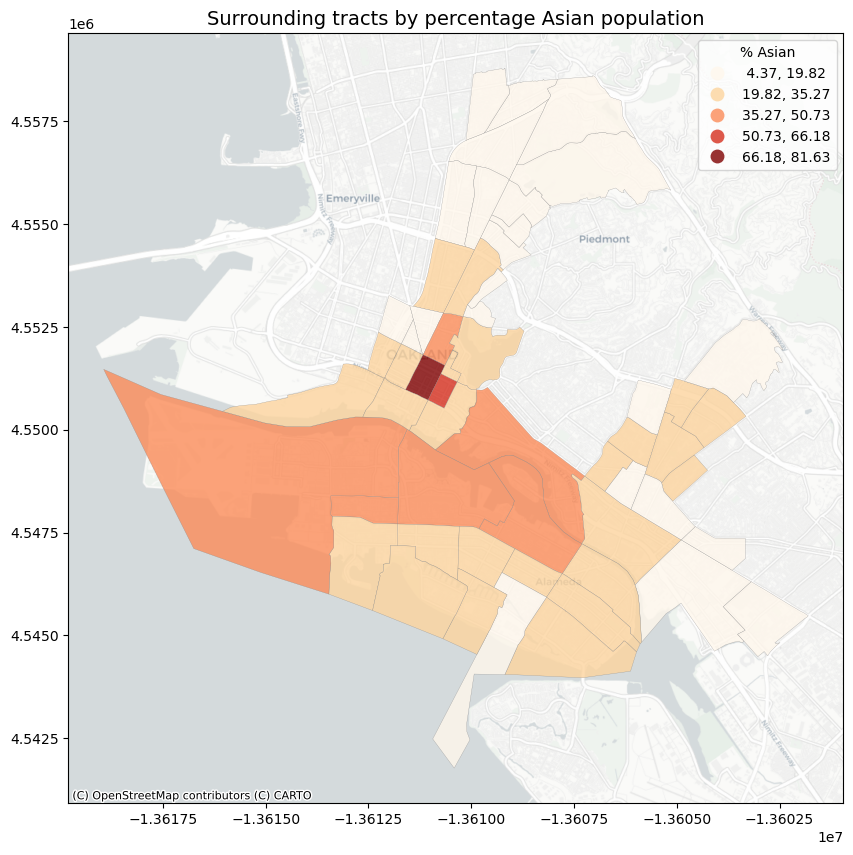

In [29]:
ax_as = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Asian',
                         legend=True,
                         cmap='OrRd',
                         scheme='equal_interval',
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': '% Asian'
                         })
cx.add_basemap(ax_as, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage Asian population",
          fontsize=14,
          color="black");

We considered low-income households as those with incomes less than than $40,000.

In [30]:
joined_census_data['Low_Income'] = joined_census_data['Less than $10,000'] + joined_census_data['$10,000 to $14,999'] +joined_census_data['$15,000 to $19,999'] +  joined_census_data['$20,000 to $24,999'] +  joined_census_data['$25,000 to 29,999'] + joined_census_data['$30,000 to $34,999'] + joined_census_data['$35,000 to $39,999']

In [31]:
joined_census_data['PCT_Low_Income'] = joined_census_data['Low_Income']/joined_census_data['Households']*100

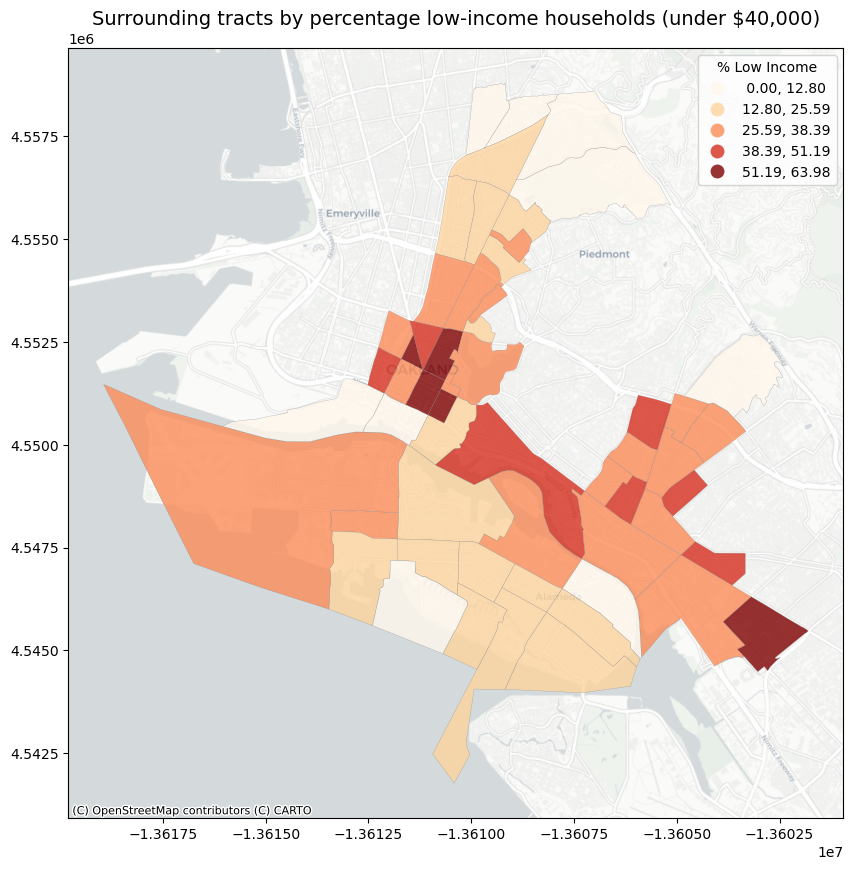

In [32]:
ax_li = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Low_Income',
                         legend=True,
                         cmap='OrRd',
                         scheme='equal_interval',
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                              'loc': 'upper right',
                              'bbox_to_anchor':(1,1),
                              'title': '% Low Income'
                         })
cx.add_basemap(ax_li, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage low-income households (under $40,000)",
          fontsize=14,
          color="black");

In [33]:
joined_census_data['PCT_Take_Transit'] = joined_census_data['Public Transportation (Includes Taxicab)']/joined_census_data['Workers 16 years and over']*100

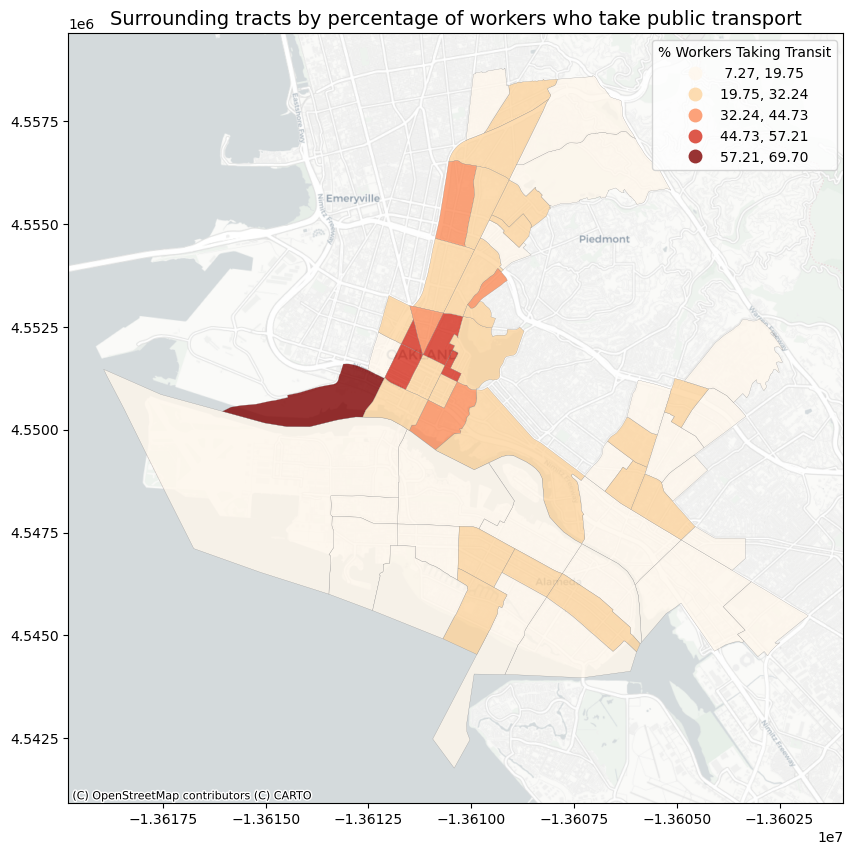

In [34]:
ax_tr = joined_census_data.plot(figsize=(12,10),
                         column='PCT_Take_Transit',
                         legend=True,
                         cmap='OrRd',
                         scheme='equal_interval',
                         linewidth=0.2,
                         edgecolor='grey',
                         alpha=0.8,
                         legend_kwds={
                             'loc': 'upper right',
                             'bbox_to_anchor':(1,1),
                             'title': '% Workers Taking Transit'
                         })
cx.add_basemap(ax_tr, source=cx.providers.CartoDB.Positron)
plt.title(label="Surrounding tracts by percentage of workers who take public transport",
          fontsize=14,
          color="black");

From looking at these maps, the tracts with more low income households and greater transit ridership do seem to be aligned with those tracts that have more people of color.

#### Highest Transit Ridership Tracts

Given that there seemed to be some tracts with significantly high transit ridership, we were particularly interested in the mode share of households in the area, and so we determined the five tracts that had the most transit ridership along each bus line. In this file, we show these for the 51A line. We first load the Census data and the dataset containing the geometries and join the two together.

In [108]:
census_data_51a = pd.read_csv("data/51a-tract-data/tracts_data_51a.csv")
geom_data_51a = pd.read_csv("data/51a-tract-data/tracts_51A.csv")
geom_data_51a = geom_data_51a.rename(columns={"GEOID": "FIPS"})
geom_data_51a = geom_data_51a.loc[:, ["FIPS", "geometry"]]
data_51a = census_data_51a.merge(right=geom_data_51a, on="FIPS")

We then make this dataframe a geodataframe.

In [109]:
data_51a["geometry"] = gpd.GeoSeries.from_wkt(data_51a["geometry"])
data_51a = gpd.GeoDataFrame(data_51a, geometry="geometry")

We updated the headers of these columns as they were very long.

In [110]:
modes = ["Drove Alone", "Carpooled", "Public Transportation (Includes Taxicab)", "Motorcycle", "Bicycle", "Walked", "Other Means"]

for i in range(7):
    data_51a = data_51a.rename(columns={"Workers 16 Years and Over: " + modes[i]: modes[i]})

We first determine these top five tracts.

In [38]:
top_5_transit_tracts = data_51a.sort_values(by="Public Transportation (Includes Taxicab)", ascending = False).head(5)

We first plot the count of residents using public transit using `pandas`'s `bar.h` function.

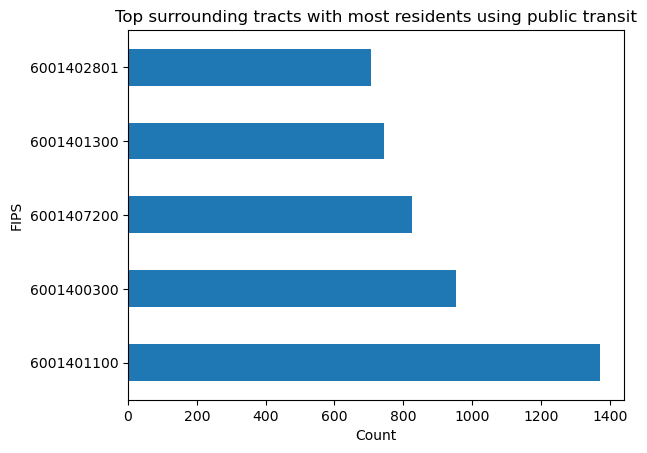

In [39]:
top_5_transit_tracts.plot.barh(x="FIPS",
                            y="Public Transportation (Includes Taxicab)",
                            xlabel="Count",
                            title="Top surrounding tracts with most residents using public transit",
                            legend=False);

As we learned about the `plotly` library the following week, we improved upon the chart by making an interactive bar chart that also showed the overall mode share of these tracts, with the interactivity allowing a viewer to see the specific counts for each mode. We converted our dataframe to be in a "long" dataframe format to work with `plotly`'s `bar` function.

In [111]:
top_5_transit_tracts['Area Name'] = top_5_transit_tracts['Area Name'].str.replace("Census Tract ", "")

In [112]:
top_5_transit_tracts_long = pd.melt(top_5_transit_tracts, id_vars='Area Name', value_vars=modes)

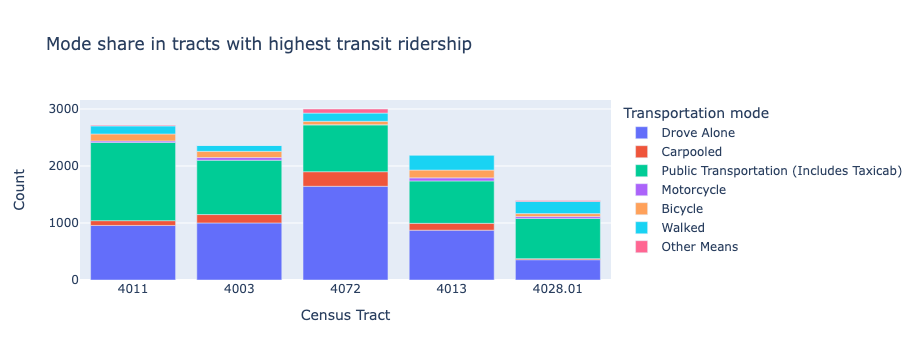

In [113]:
fig_transit_tracts = px.bar(top_5_transit_tracts_long, x="Area Name", y="value", color="variable", 
                            labels={
                                "value": "Count",
                                "variable": "Transportation mode",
                            },
                            title="Mode share in tracts with highest transit ridership")

fig_transit_tracts.update_layout(xaxis_title="Census Tract")
fig_transit_tracts.show()

We find that the tracts that have the highest transit ridership also seem to have higher counts of walking and biking. We recognize that taking transit often involves active transportation for first and last mile access, .

## Bus performance

#### On-time performance

We reached out to AC Transit for data on delays and performance. They shared with us data on on-time performance for these three lines, which we have ploted below.

In [43]:
otp_19 = pd.read_csv('data/on-time performance/On Time Performance_Line 19 (2022).csv')
otp_20 = pd.read_csv('data/on-time performance/On Time Performance_Line 20 (2022).csv')
otp_51A = pd.read_csv('data/on-time performance/On Time Performance_Line 51A (2022).csv')

In [44]:
def plot_otp(df, i, line):
    df['Eastbound OTP'] = df['Eastbound OTP']*100
    df['Westbound OTP'] = df['Westbound OTP']*100
    
    f = df.plot(ax=axes_otp[i], rot=90, legend=False, figsize=(10,5))
    f.set_ylim(ymin=0, ymax=100)

    if i == 0:
        f.set_ylabel("Percent")
    else:
        f.set_yticks([])
        
    f.set_xticks(np.linspace(0,11,12), labels=["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"])
    f.set_title("Line " + line)
    
    if i == 2:
        f.legend(loc = 'lower right')

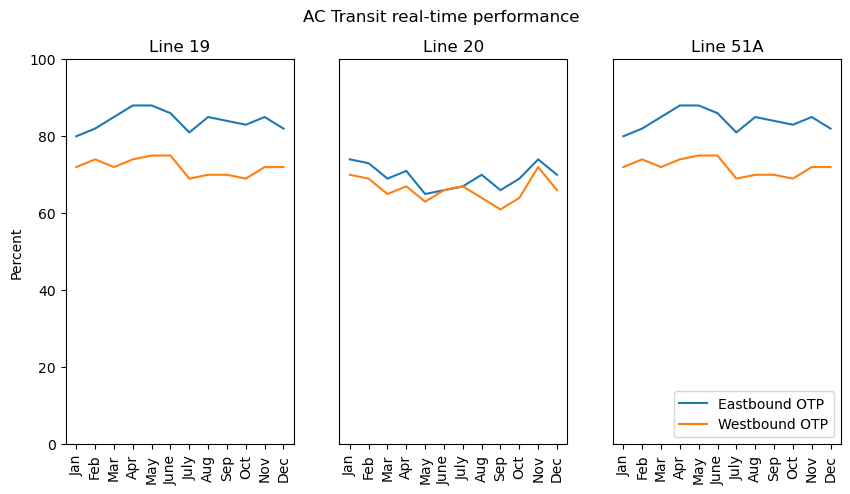

In [45]:
fig_otp, axes_otp = plt.subplots(nrows=1, ncols=3)
plot_otp(otp_19, 0, "19")
plot_otp(otp_20, 1, "20")
plot_otp(otp_51A, 2, "51A")
fig_otp.suptitle("AC Transit real-time performance");

#### Real-time delays

We collected real-time transit data via Open 511 SIRI APIs. This data is provided in an XML format and has information such as bus expected and aimed arrival and departure times. To determine which stops have the greatest average delays, we are gathering this real-time delay data during different times of day (peak and off-peak, AM and PM) throughout the week. The following interactive maps show bus stops with average delays over five minutes, which is AC Transit's guidance for defining a bus that is not on time.

In [136]:
stops_shp_file = gpd.read_file('data/bus-stops/UniqueStops_Fall22.shp')
stops_shp_file.to_file('data/bus-stops/UniqueStops_Fall22.shp', driver='GeoJSON')

We had shapefiles with data on all bus stops from AC Transit's Data and Resource Center, and we had previously filtered these by line for the three bus lines we consider.

In [137]:
delays_19 = pd.read_csv('data/real-time delays/Line 19.csv')
delays_20 = pd.read_csv('data/real-time delays/Line 20.csv')
delays_51A = pd.read_csv('data/real-time delays/Line 51A.csv')

We join these bus stops associated with each line to the shapefile that has a `geometry` column for us to plot.

In [138]:
joined_geom_data_19 = delays_19.merge(stops_shp_file, left_on='stop_code', right_on='stp_511_id', how = 'left')
joined_geom_data_20 = delays_20.merge(stops_shp_file, left_on='stop_code', right_on='stp_511_id', how = 'left')
joined_geom_data_51A = delays_51A.merge(stops_shp_file, left_on='stop_code', right_on='stp_511_id', how = 'left')

The following function takes in a geodataframe and filters it so that the remaining rows are only those stops that have average delays of greater than five minutes.

In [139]:
def filter_for_delays(geom_data):
    geom_data = geom_data[geom_data.iloc[:,5] > 300]
    geom_data.columns.values[5] = "Average Delay"
    geom_data['lon'] = geom_data.geometry.apply(lambda p: p.x)
    geom_data['lat'] = geom_data.geometry.apply(lambda p: p.y)
    
    return geom_data

The following function takes in a geodataframe and plots the filtered stops.

In [140]:
def generate_map(geom_data):
    filtered_geom_data = filter_for_delays(geom_data)
    fig = px.scatter_mapbox(filtered_geom_data,
                    lat='lat',
                    lon='lon',
                    zoom=12,
                    hover_name='stop_name',
                    hover_data=["Average Delay"],
                    mapbox_style="carto-positron")
    # options on the layout
    fig.update_layout(
        width = 800,
        height = 800,
        title_x=0.5
    )
    return fig

/tmp/ipykernel_75/2253539602.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_75/2253539602.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



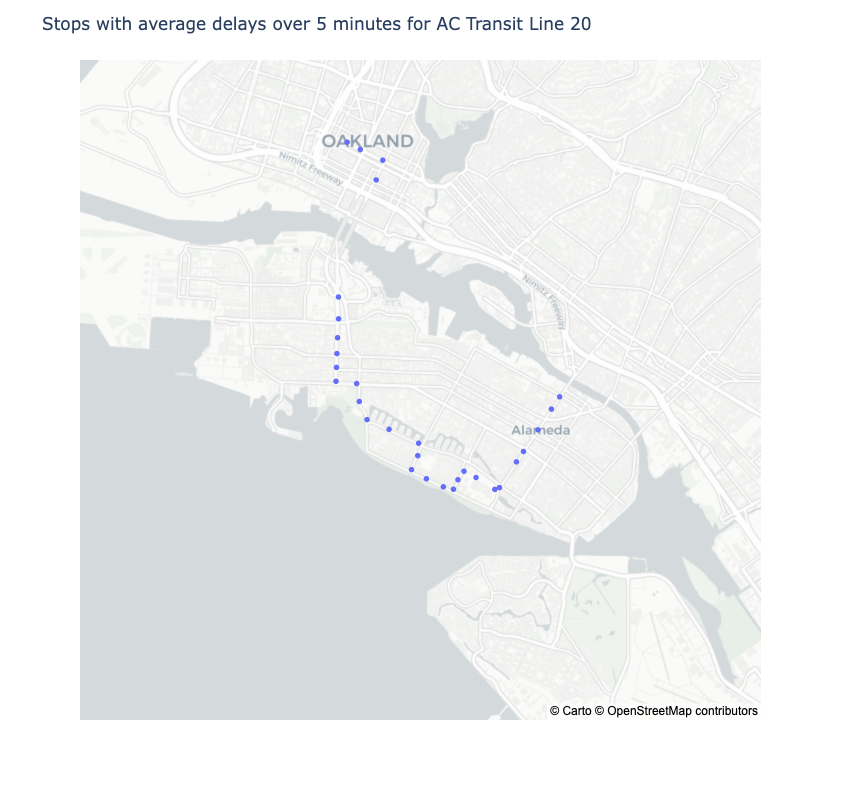

In [145]:
map_20 = generate_map(joined_geom_data_20)
map_20 = map_20.update_layout(title = 'Stops with average delays over 5 minutes for AC Transit Line 20')
map_20

/tmp/ipykernel_75/2253539602.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_75/2253539602.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



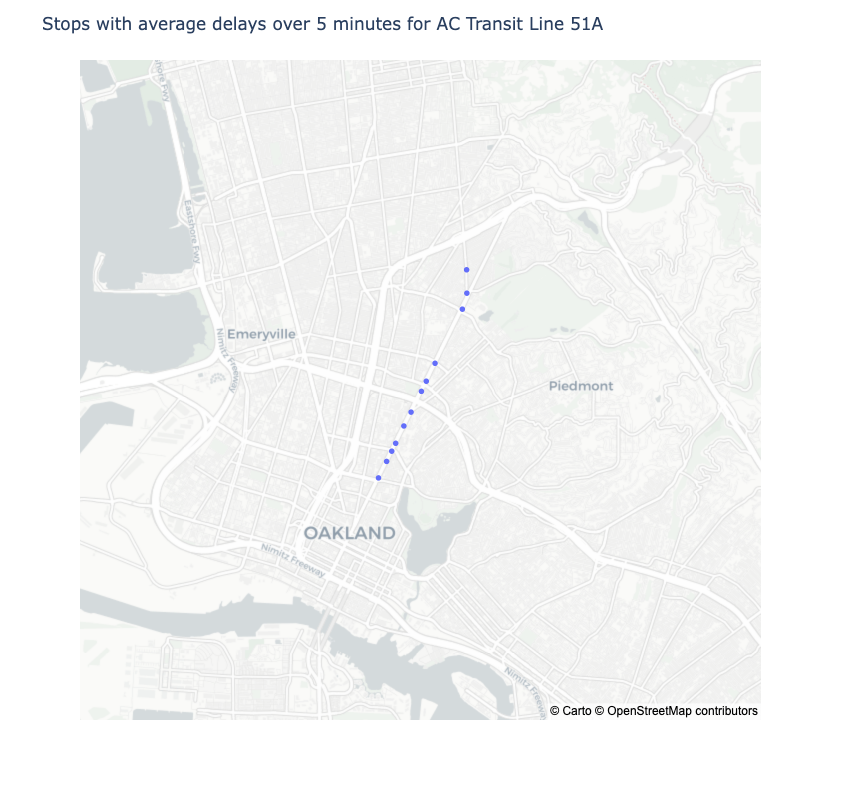

In [146]:
map_51A = generate_map(joined_geom_data_51A)
map_51A = map_51A.update_layout(title = 'Stops with average delays over 5 minutes for AC Transit Line 51A')
map_51A

As we can see from the maps above, line 20 has significant delays. 

## Division of work

In this file, the visuals were made by:
* Bus routes map: Purva
* 4 census data maps: data collected and plotted by Hamzah, basemap added by Purva
* "Bad" transit counts bar graph: Purva
* "Fixed" interactive mode share bar graph: Purva
* AC Transit on-time performance: plotted by Jackson, edited by Purva
* 2 interactive average delay maps: data collected by Purva, plotted and tooltip added by Jackson

All three members collected and used Census data for this assignemnt as well as previous assignments. Jackson additionally worked with on-time performance data provided by AC Transit and the average bus delays that Purva calculated. Purva collected real-time data by calling the 511 API, parsing through the XML response, and calculating the average delays.

All code in this file was compiled and documented by Purva. 